# creating dataframe

In [297]:
import kagglehub

# download latest version
path = kagglehub.dataset_download("rodolfofigueroa/spotify-12m-songs")
print("Path to dataset files:", path)

Path to dataset files: /Users/cjz/.cache/kagglehub/datasets/rodolfofigueroa/spotify-12m-songs/versions/1


In [298]:
import pandas as pd
import os

cols = ["name", "artists", "key", "mode", "tempo", "year"]
audio_feats = ["energy", "valence", "danceability", "acousticness"]
df = pd.read_csv(os.path.join(path, "tracks_features.csv"), usecols=cols+audio_feats).dropna()

# feature engineering to take into account interplay between features
df["energy*valence"] = df["energy"] * df["valence"]
audio_feats.append("energy*valence")

df.describe()

,danceability,energy,key,mode,acousticness,valence,tempo,year,energy*valence
count,1.204022e+06,1.204022e+06,1.204022e+06,1.204022e+06,1.204022e+06,1.204022e+06,1.204022e+06,1.204022e+06,1.204022e+06
mean,4.930560e-01,5.095357e-01,5.194155e+00,6.714595e-01,4.467521e-01,4.279866e-01,1.176343e+02,2.007328e+03,2.499200e-01
std,1.896692e-01,2.946840e-01,3.536727e+00,4.696827e-01,3.852013e-01,2.704845e-01,3.093707e+01,1.210118e+01,2.215328e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.560000e-01,2.520000e-01,2.000000e+00,0.000000e+00,3.760000e-02,1.910000e-01,9.405400e+01,2.002000e+03,5.150725e-02
50%,5.010000e-01,5.240000e-01,5.000000e+00,1.000000e+00,3.890000e-01,4.030000e-01,1.167260e+02,2.009000e+03,1.947445e-01
75%,6.330000e-01,7.660000e-01,8.000000e+00,1.000000e+00,8.610000e-01,6.440000e-01,1.370460e+02,2.015000e+03,4.054760e-01
max,1.000000e+00,1.000000e+00,1.100000e+01,1.000000e+00,9.960000e-01,1.000000e+00,2.489340e+02,2.020000e+03,9.791040e-01


In [299]:
df[audio_feats].corr()

,energy,valence,danceability,acousticness,energy*valence
energy,1.000000,0.399531,0.283015,-0.796242,0.729303
valence,0.399531,1.000000,0.563438,-0.268837,0.841660
danceability,0.283015,0.563438,1.000000,-0.285748,0.456552
acousticness,-0.796242,-0.268837,-0.285748,1.000000,-0.540070
energy*valence,0.729303,0.841660,0.456552,-0.540070,1.000000


In [300]:
import ast

try:
    # convert string representation of lists to actual lists
    df['artists'] = df['artists'].apply(ast.literal_eval)
except:
    print("✅ Artist col already transformed")

df = df[df["year"] >= 1955]

df.info()

df.tail(5).T

<class 'pandas.core.frame.DataFrame'>
Index: 1201578 entries, 0 to 1204024
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   name            1201578 non-null  object 
 1   artists         1201578 non-null  object 
 2   danceability    1201578 non-null  float64
 3   energy          1201578 non-null  float64
 4   key             1201578 non-null  int64  
 5   mode            1201578 non-null  int64  
 6   acousticness    1201578 non-null  float64
 7   valence         1201578 non-null  float64
 8   tempo           1201578 non-null  float64
 9   year            1201578 non-null  int64  
 10  energy*valence  1201578 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 110.0+ MB


,1204020,1204021,1204022,1204023,1204024
name,Gospel of Juke,Prism Visions,Tokyo 360,Yummy!,That's The Way It Is
artists,[FVLCRVM],[FVLCRVM],[FVLCRVM],[FVLCRVM],[FVLCRVM]
danceability,0.264,0.796,0.785,0.665,0.736
energy,0.966,0.701,0.796,0.856,0.708
key,5,11,9,6,2
mode,0,0,0,0,0
acousticness,0.00935,0.104,0.0304,0.00007,0.0168
valence,0.415,0.781,0.467,0.227,0.204
tempo,159.586,121.98,121.996,124.986,117.991
year,2014,2014,2014,2014,2014


In [301]:
to_int16 = ["tempo", "year"]
to_float32 = [feat for feat in audio_feats if df[feat].dtype == "float64"]

df[to_int16] = df[to_int16].astype("int16")
df[to_float32] = df[to_float32].astype("float32")

print(df.info())
df.head(3).T

<class 'pandas.core.frame.DataFrame'>
Index: 1201578 entries, 0 to 1204024
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   name            1201578 non-null  object 
 1   artists         1201578 non-null  object 
 2   danceability    1201578 non-null  float32
 3   energy          1201578 non-null  float32
 4   key             1201578 non-null  int64  
 5   mode            1201578 non-null  int64  
 6   acousticness    1201578 non-null  float32
 7   valence         1201578 non-null  float32
 8   tempo           1201578 non-null  int16  
 9   year            1201578 non-null  int16  
 10  energy*valence  1201578 non-null  float32
dtypes: float32(5), int16(2), int64(2), object(2)
memory usage: 73.3+ MB
None


,0,1,2
name,Testify,Guerrilla Radio,Calm Like a Bomb
artists,[Rage Against The Machine],[Rage Against The Machine],[Rage Against The Machine]
danceability,0.47,0.599,0.315
energy,0.978,0.957,0.97
key,7,11,7
mode,1,1,1
acousticness,0.0261,0.0129,0.0234
valence,0.503,0.489,0.37
tempo,117,103,149
year,1999,1999,1999


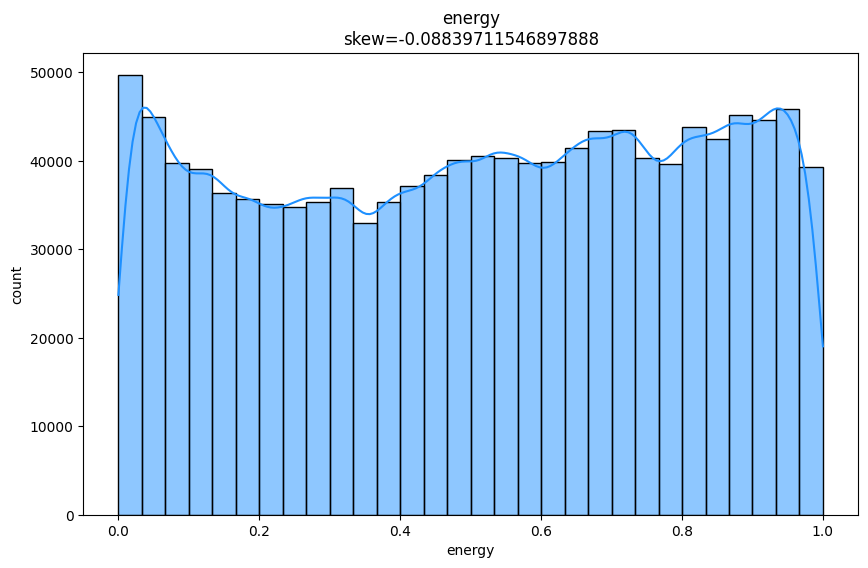

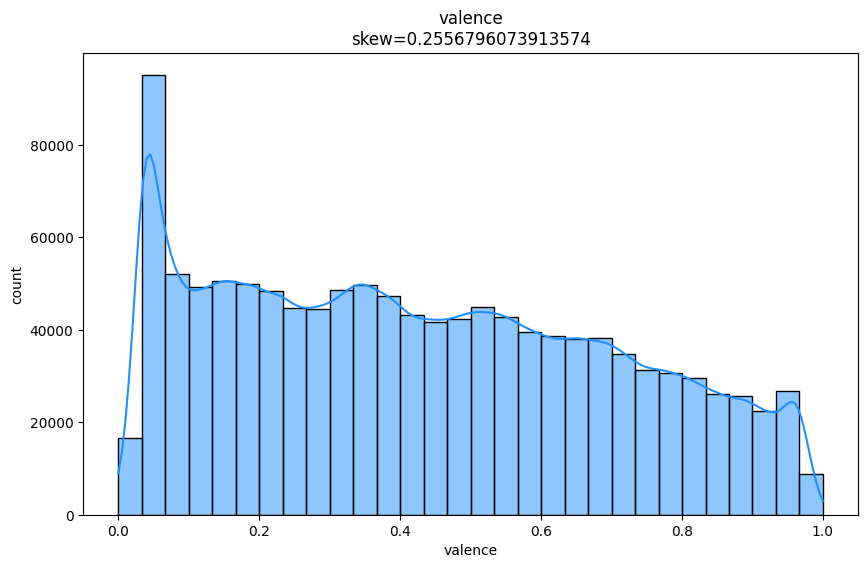

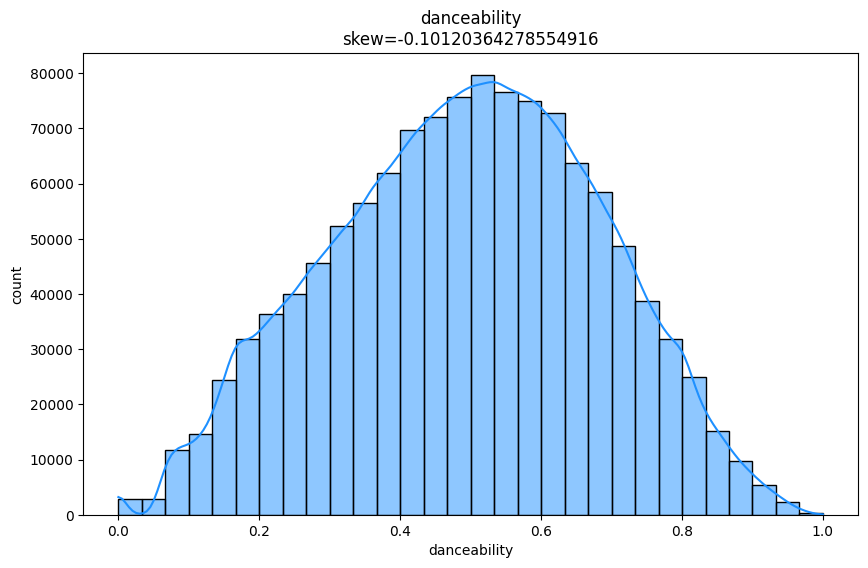

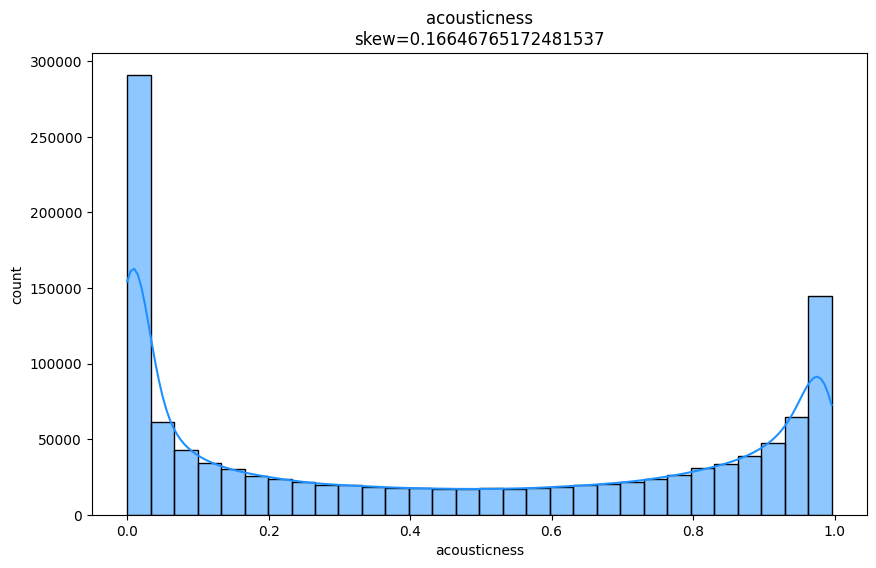

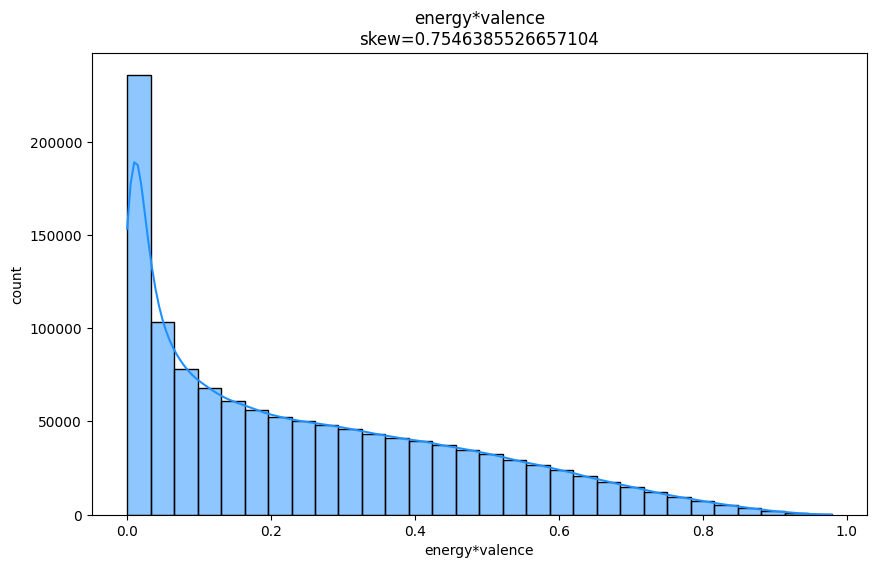

In [302]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

for feat in audio_feats:
    plt.figure(figsize=(10,6))
    sns.histplot(df[feat], bins=30, kde=True, color="dodgerblue")
    plt.title(f"{feat}\nskew={df[feat].skew()}")
    plt.ylabel("count")
    
    plt.show()
    
transformed = 0

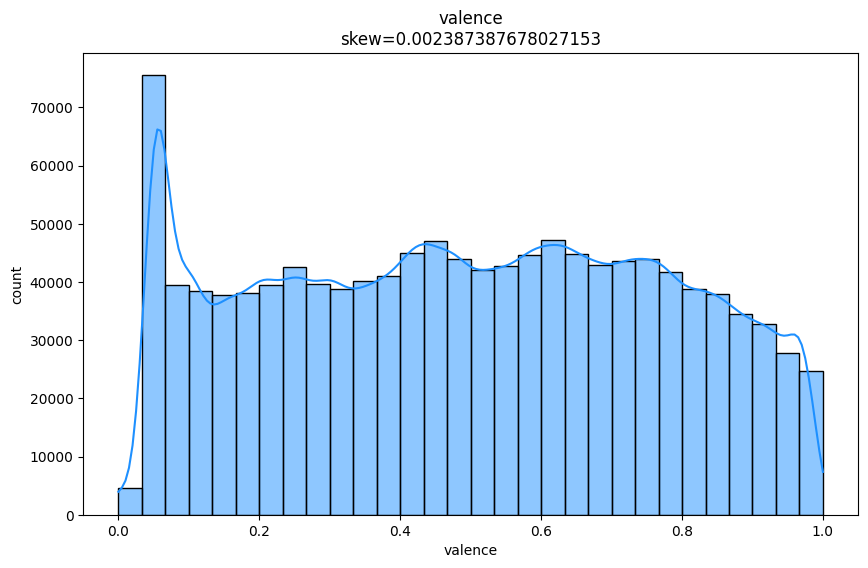

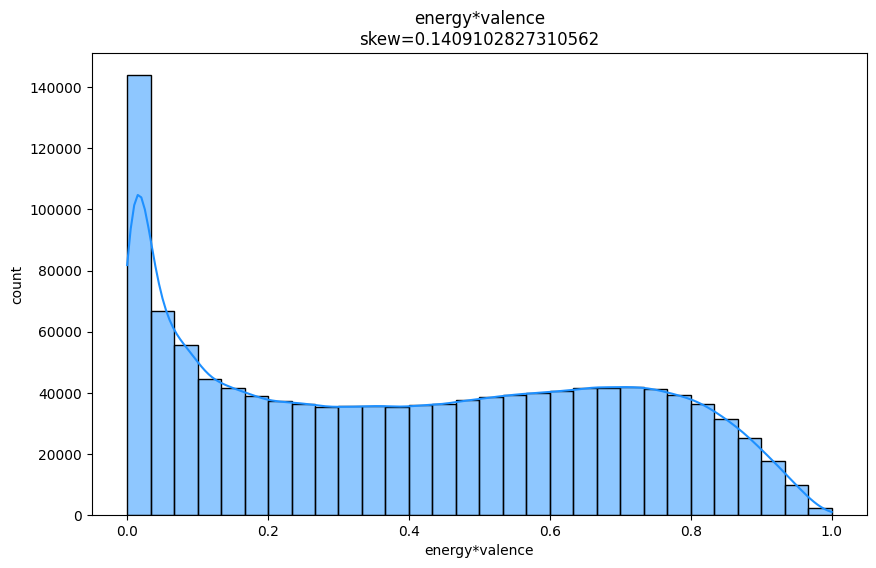

In [303]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

# yeo-johnson stabilizes valence spike, scaler brings it back to range 0-1
vibe_transformer = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson', standardize=True)),
    ('scaler', MinMaxScaler())
])

if transformed == 0:
    df[['valence', 'energy*valence']] = vibe_transformer.fit_transform(df[['valence', 'energy*valence']])
    transformed = 1
else:
    print("✅ Valence and energy*valence already transformed")

for col in ["valence", "energy*valence"]:
    plt.figure(figsize=(10,6))
    sns.histplot(df[col], bins=30, kde=True, color="dodgerblue")
    plt.title(f"{col}\nskew={df[col].skew()}")
    plt.ylabel("count")
    plt.show()

year
2020    69725
2019    67276
2006    56945
2007    56287
2018    56167
        ...  
1961      623
1956      508
1958      473
1957      412
1955      179
Name: count, Length: 66, dtype: int64


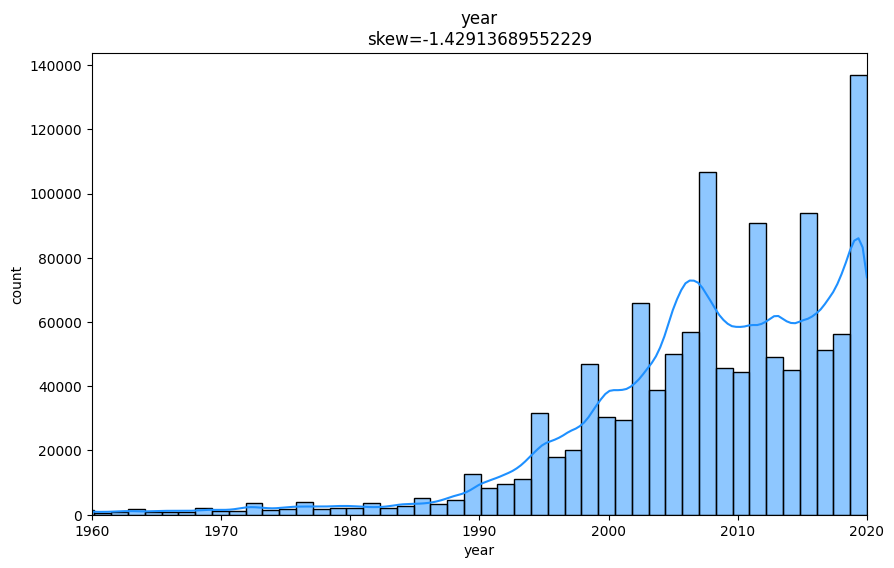

In [304]:
print(df["year"].value_counts())
plt.figure(figsize=(10,6))
plt.xlim(1960, 2020)
sns.histplot(df["year"], bins=50, kde=True, color="dodgerblue")
plt.title(f"{"year"}\nskew={df["year"].skew()}")
plt.ylabel("count")
plt.show()

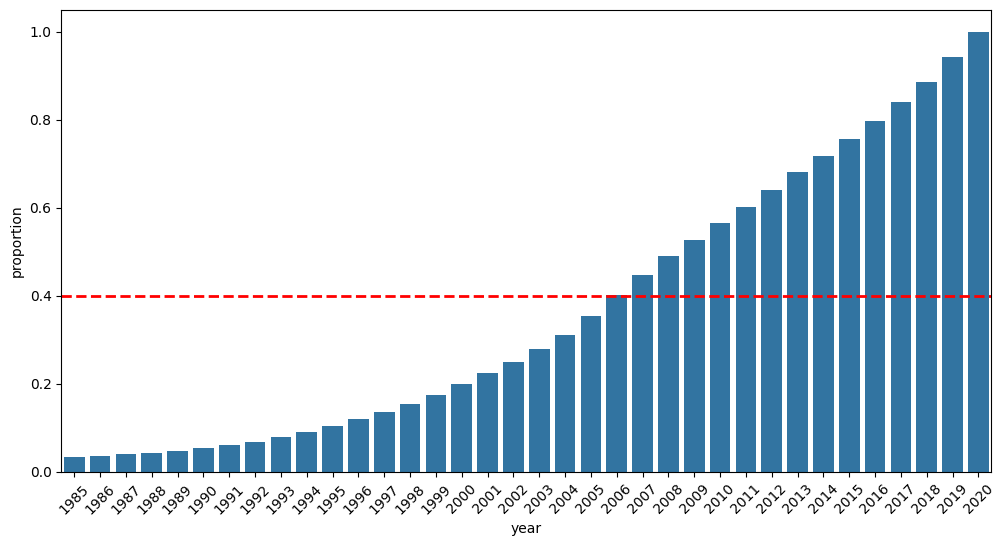

split year: 2006


In [305]:
props = df["year"].value_counts(normalize=True).sort_index(ascending=True)
props_cumsum = props.cumsum()

props_cumsum = pd.Series(props_cumsum[30:], index=props.keys()[30:])

plt.figure(figsize=(12,6))
sns.barplot(props_cumsum)
plt.axhline(y=0.4, color='red', linestyle='--', linewidth=2)
plt.xticks(rotation=45)
plt.show()

split_year = (props_cumsum >= 0.4).idxmax() # find year that splits dataset into 40% of songs released earlier, 60% released later
print(f"split year: {split_year}")

In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1201578 entries, 0 to 1204024
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   name            1201578 non-null  object 
 1   artists         1201578 non-null  object 
 2   danceability    1201578 non-null  float32
 3   energy          1201578 non-null  float32
 4   key             1201578 non-null  int64  
 5   mode            1201578 non-null  int64  
 6   acousticness    1201578 non-null  float32
 7   valence         1201578 non-null  float32
 8   tempo           1201578 non-null  int16  
 9   year            1201578 non-null  int16  
 10  energy*valence  1201578 non-null  float32
dtypes: float32(5), int16(2), int64(2), object(2)
memory usage: 73.3+ MB


In [307]:
df.reset_index(drop=True, inplace=True)

# mapping from key(0-11) to Camelot
# 0 = C, 1 = C#, 2 = D, etc... 11 = B
major_map = {0: '8B', 1: '3B', 2: '10B', 3: '5B', 4: '12B', 5: '7B', 
             6: '2B', 7: '9B', 8: '4B', 9: '11B', 10: '6B', 11: '1B'}

minor_map = {0: '5A', 1: '12A', 2: '7A', 3: '2A', 4: '9A', 5: '4A', 
             6: '11A', 7: '6A', 8: '1A', 9: '8A', 10: '3A', 11: '10A'}

try:
    # create two helper series
    major_col = df["key"].map(major_map)
    minor_col = df["key"].map(minor_map)

    # pick conditionally between two series based on mode col
    df["camelot"] = major_col.where(df["mode"] == 1, minor_col)
    
    df = df.drop(columns=["key", "mode"]) # columns now unnecessary
except:
    print("✅ Camelot col created; key and mode already deleted")

# dict to store song ids from each camelot
throwback_camelot = df[df["year"] <= split_year].groupby("camelot").groups
modern_camelot = df[df["year"] > split_year].groupby('camelot').groups

{'10A': 16879, '10B': 47125, '11A': 10271, '11B': 35095, '12A': 8622, '12B': 20898, '1A': 5047, '1B': 13362, '2A': 3696, '2B': 12831, '3A': 12140, '3B': 25140, '4A': 12579, '4B': 19377, '5A': 10939, '5B': 13063, '6A': 11926, '6B': 18848, '7A': 13063, '7B': 28873, '8A': 19716, '8B': 49967, '9A': 18961, '9B': 53022}


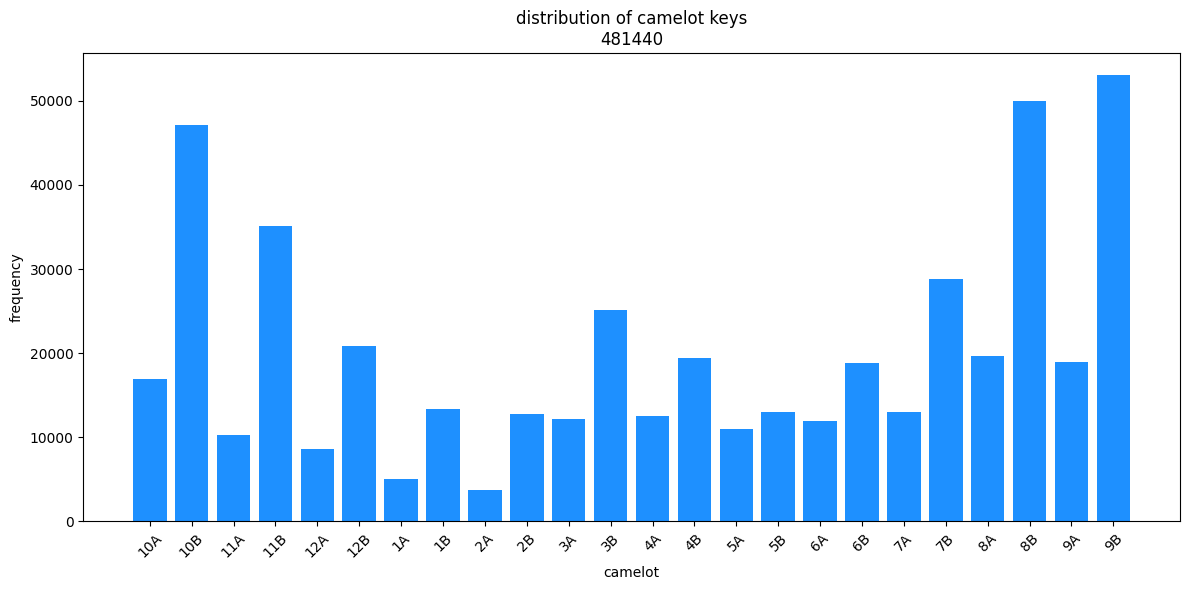

{'10A': 30141, '10B': 64646, '11A': 19534, '11B': 45266, '12A': 17702, '12B': 27229, '1A': 10453, '1B': 21006, '2A': 7506, '2B': 20785, '3A': 22719, '3B': 44719, '4A': 22849, '4B': 30214, '5A': 18282, '5B': 15314, '6A': 18979, '6B': 23208, '7A': 19555, '7B': 35379, '8A': 33026, '8B': 70046, '9A': 30423, '9B': 71157}


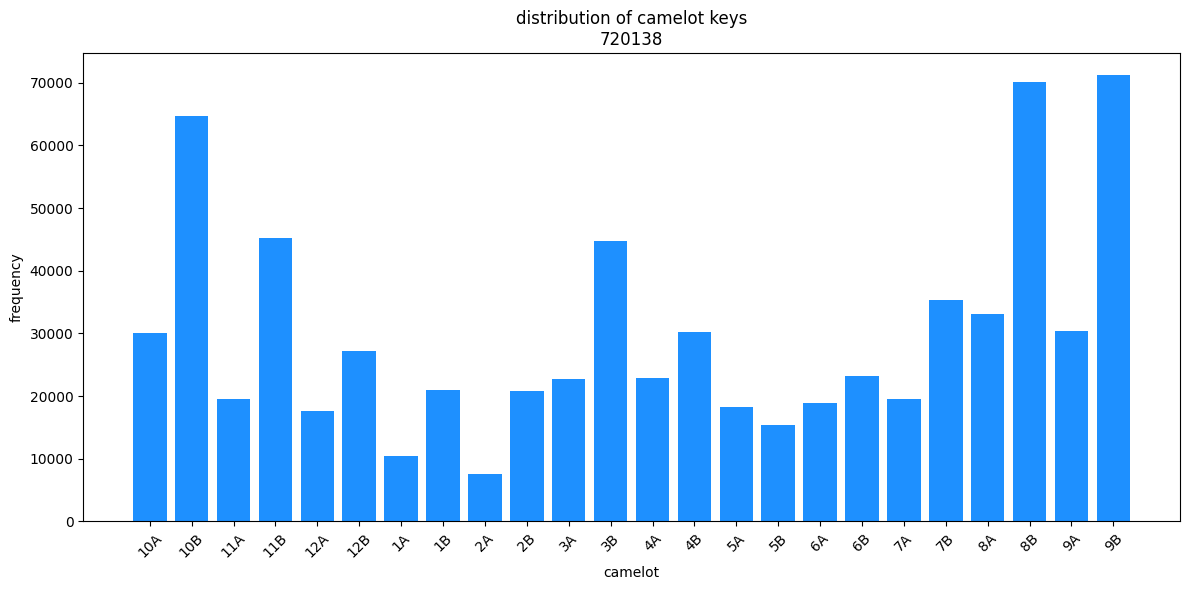

In [308]:
for camelot in [throwback_camelot, modern_camelot]:
    # dictionary storing number of songs in each camelot
    sizes = {key: len(camelot[key]) for key in camelot}

    print(sizes)

    plt.figure(figsize=(12,6))
    plt.bar(sizes.keys(), sizes.values(), color="dodgerblue")
    plt.xlabel("camelot")
    plt.xticks(rotation=45)
    plt.ylabel("frequency")
    plt.title(f"distribution of camelot keys\n{sum(sizes.values())}")
    plt.tight_layout()
    plt.show()

In [309]:
final_df = df.copy()

final_df

,name,artists,danceability,energy,acousticness,valence,tempo,year,energy*valence,camelot
0,Testify,[Rage Against The Machine],0.470,0.978,0.02610,0.590601,117,1999,0.732318,9B
1,Guerrilla Radio,[Rage Against The Machine],0.599,0.957,0.01290,0.577124,103,1999,0.712202,1B
2,Calm Like a Bomb,[Rage Against The Machine],0.315,0.970,0.02340,0.456997,149,1999,0.607315,9B
3,Mic Check,[Rage Against The Machine],0.440,0.967,0.16300,0.657006,96,1999,0.781078,10A
4,Sleep Now In the Fire,[Rage Against The Machine],0.426,0.929,0.00162,0.624666,127,1999,0.739471,10B
...,...,...,...,...,...,...,...,...,...,...
1201573,Gospel of Juke,[FVLCRVM],0.264,0.966,0.00935,0.503647,159,2014,0.650498,4A
1201574,Prism Visions,[FVLCRVM],0.796,0.701,0.10400,0.834268,121,2014,0.775528,10A
1201575,Tokyo 360,[FVLCRVM],0.785,0.796,0.03040,0.555680,121,2014,0.620918,8A
1201576,Yummy!,[FVLCRVM],0.665,0.856,0.00007,0.297507,124,2014,0.393715,11A


# Recommender

In [691]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

class Recommender():
    def __init__(self, final_df: pd.DataFrame,
                 modern_camelot: dict[str, list[int]],
                 throwback_camelot: dict[str, list[int]]):
        self.final_df = final_df
        self.modern_camelot = modern_camelot
        self.throwback_camelot = throwback_camelot
        self.audio_feats = ["energy", "valence", "danceability", "acousticness", "energy*valence"]
        self.weights = np.array([1.5, 1.0, 1.3, 1.2, 1.2]) # energy, valence, danceability, acousticness, energy*valence

    # function to return list of valid camelot key neighbors
    def get_harmonic_neighbors(self, camelot: str) -> list[str]:
        neighbors = []
        key = int(camelot[:-1])
        mode = camelot[-1]
        
        neighbors.append(camelot)
        neighbors.append(f"{((key - 2) % 12) + 1}{mode}")
        neighbors.append(f"{(key % 12) + 1}{mode}")
        other_mode = "A" if mode == "B" else "B"
        neighbors.append(f"{key}{other_mode}")
        
        return neighbors

    # function to get valid database of song pool to use for distance calculation rankings
    # TODO: maybe add error check / alternate functionalities in case restrictions leave too few rows (songs)?
    def get_pool_df(self, song_idx: int, 
                    time_period: str = None) -> pd.DataFrame: # time period can be either "modern" or "throwback"
        
        camelot = final_df.at[song_idx, "camelot"]
        harmonic_neighbors = self.get_harmonic_neighbors(camelot)

        pool_indices = []
        if time_period in ("modern", "throwback"):
            lookup = modern_camelot if time_period == "modern" else throwback_camelot
            for cam in harmonic_neighbors:
                pool_indices.extend(lookup.get(cam, []))
        else:  # time_period is None or anything else you treat as "both"
            for cam in harmonic_neighbors:
                pool_indices.extend(modern_camelot.get(cam, []))
                pool_indices.extend(throwback_camelot.get(cam, []))
                
        # if no neighbors in that period, early return
        if not pool_indices:
            return pd.DataFrame(columns=audio_feats)

        filter_cols = ["tempo", "year", "camelot"]
        cols = audio_feats + filter_cols

        curr_df = final_df.loc[pool_indices, cols].copy() # 
        # always grab song row from full df, not curr_df
        song_idx_vec = final_df.loc[[song_idx], cols].copy() # store copy of current song vector

        # tempo filtering
        curr_tempo = final_df.at[song_idx, "tempo"]
        curr_df = curr_df[(curr_df["tempo"] >= curr_tempo * 0.90) & (curr_df["tempo"] <= curr_tempo * 1.10)
        ]

        if song_idx not in curr_df.index:
            curr_df = pd.concat([song_idx_vec, curr_df], axis=0)

        curr_df = curr_df.drop(columns=filter_cols)
        return curr_df
    
    # function to get n recommendations for starting song at song_idx
    def get_hybrid_sim_recs(self, song_idx: int, 
                            time_period: str,
                            n: int = None) -> list[tuple]:
        
        # get filtered pool
        pool_df = self.get_pool_df(song_idx, time_period)
        
        if pool_df.empty:
            return []

        # song pool
        pool_matrix = pool_df[audio_feats].values
        
        # clean current song vector
        curr_song_vec = pool_df.loc[song_idx, audio_feats].values.reshape(1, -1)
        
        # calculate cosine similarities
        cos_sim = cosine_similarity(curr_song_vec, pool_matrix)[0]
        
        # calculate euclidean similarities with weighting
        euc_weights = np.array([1.5, 1.0, 1.3, 1.2, 1.2]) # energy, valence, danceability, acousticness, energy*valence
        euc_dist = euclidean_distances(curr_song_vec * euc_weights, pool_matrix * euc_weights)[0]
        euc_sim = 1 / (1 + euc_dist)
        
        # compute score
        hybrid_scores = np.power((0.4 * cos_sim) + (0.6 * euc_sim), 3)
        hybrid_scores = np.clip(hybrid_scores, 0, 1).astype("float16")
        
        # create list of tuples using original indices from pool_df and the scores
        combined = list(zip(pool_df.index, hybrid_scores))
        
        # sort desc by score (second element in tuple) - O(nlogn) for filtered pool
        sorted_recs = sorted(combined, key=lambda x: x[1], reverse=True)
        
        if n == None:
            return sorted_recs[1:]
        return sorted_recs[1:n+1]


# search

In [692]:
# songs: groupby final_df directly
song_to_idx = {name: group.index.tolist() for name, group in final_df.groupby('name')}

# artists: explode first, then groupby
exploded = final_df.explode('artists')
artist_to_idx = {artist: group.index.tolist() for artist, group in exploded.groupby('artists')}

In [693]:
# check matches for bruno mars
faded_indices = artist_to_idx["Bruno Mars"]  # Or from groupby
for idx in faded_indices:
    row_name = final_df.iloc[idx]["name"]
    print(f'idx {idx}: "{row_name}" | len={len(row_name)} | repr={repr(row_name)}')

# spot-check
exploded[exploded["artists"].str.contains("Bruno Mars", na=False, case=False)].sample(5)


idx 19257: "BLOW (with Chris Stapleton & Bruno Mars)" | len=40 | repr='BLOW (with Chris Stapleton & Bruno Mars)'
idx 30454: "Wake Up in the Sky" | len=18 | repr='Wake Up in the Sky'
idx 72204: "BLOW (with Chris Stapleton & Bruno Mars)" | len=40 | repr='BLOW (with Chris Stapleton & Bruno Mars)'
idx 94525: "Please Me" | len=9 | repr='Please Me'
idx 529470: "Billionaire (feat. Bruno Mars)" | len=30 | repr='Billionaire (feat. Bruno Mars)'
idx 688271: "Uptown Funk (feat. Bruno Mars)" | len=30 | repr='Uptown Funk (feat. Bruno Mars)'
idx 734374: "Young Girls" | len=11 | repr='Young Girls'
idx 734375: "Locked out of Heaven" | len=20 | repr='Locked out of Heaven'
idx 734376: "Gorilla" | len=7 | repr='Gorilla'
idx 734377: "Treasure" | len=8 | repr='Treasure'
idx 734378: "Moonshine" | len=9 | repr='Moonshine'
idx 734379: "When I Was Your Man" | len=19 | repr='When I Was Your Man'
idx 734380: "Natalie" | len=7 | repr='Natalie'
idx 734381: "Show Me" | len=7 | repr='Show Me'
idx 734382: "Money Make 

,name,artists,danceability,energy,acousticness,valence,tempo,year,energy*valence,camelot
1006988,Locked out of Heaven - The M Machine Remix,Bruno Mars,0.532,0.822,0.02800,0.279675,170,2013,0.361629,7B
30454,Wake Up in the Sky,Bruno Mars,0.799,0.579,0.00381,0.449600,142,2020,0.418022,9A
1006986,Locked out of Heaven - CAZZETTE's Answering Ma...,Bruno Mars,0.785,0.764,0.02250,0.712513,127,2013,0.727344,7A
997470,Chunky,Bruno Mars,0.571,0.539,0.02080,0.790165,202,2016,0.641522,4A
854704,Wake Up in the Sky,Bruno Mars,0.800,0.578,0.00381,0.453831,143,2018,0.420945,9A


# DJQueue

In [ ]:
import random

class DJQueue():
    def __init__(self):
        self.queue = []
        self.played = []
        self.now_playing = None
        
    # add song to end of queue
    def add(self, song_idxs: list[int]):
        self.queue.extend(song_idxs)
        
    def play(self):
        if self.now_playing is None and self.queue:
            self.now_playing = self.queue.pop(0)
        return self.now_playing
        
    # use when current song finishes or skipping to next song
    def switch_to_next(self):
        if not self.queue and self.now_playing is None:
            print("❌ Nothing in queue")
            return
        
        if self.now_playing is not None:
            self.played.append(self.now_playing)
            
        if not self.queue:
            self.now_playing = None
            return
            
        self.now_playing = self.queue.pop(0)
        return self.now_playing
    
    # general case of switch_to_next() with different idx inputs
    def skip_to_song(self, idx: int = 0):
        if not self.queue:
            print("❌ Nothing in queue")
            self.now_playing = None
            return
        if idx < 0 or idx >= len(self.queue):
            print("❌ Invalid index")
            return
        
        if self.now_playing is not None:
            self.played.append(self.now_playing)
        
        self.now_playing = self.queue[idx]
        self.queue = self.queue[idx+1:]
        return self.now_playing
    
    def remove(self, song_idx: int):
        try:
            if self.now_playing == song_idx:
                self.now_playing = None
            self.queue.remove(song_idx)
        except ValueError:
            print("❌ Song not in queue")
            
    def shuffle(self, shuffle_after_idx: int = 0):
        if 0 <= shuffle_after_idx < len(self.queue):
            no_shuffle = self.queue[:shuffle_after_idx]
            shuffle = self.queue[shuffle_after_idx:]
            random.shuffle(shuffle)
            self.queue = no_shuffle + shuffle
        return self.queue
    
    def get_queue(self):
        return self.queue
    
    # get current song
    def get_current(self):
        return self.now_playing
    
    def get_length(self):
        return len(self.queue)
    
    def get_history(self):
        return self.played
    
queue = DJQueue()
queue.add([5, 23, 4, 24, 21, 32, 52, 35])
queue.play()
queue.add([5])
print(queue.get_current())
print(queue.get_queue())


5
[23, 35, 52, 24, 21, 32, 4, 5]


# AudienceSuggestions

In [685]:
class AudienceSuggestions():
    def __init__(self):
        pass

# SearchSystem

In [ ]:
class SearchSystem():
    def __init__(self):
        pass

# CamelotApp

In [ ]:
class CamelotApp():
    def __init__(self, df, search, recommender, suggestions):
        self.queue = DJQueue()
        self.search = SearchSystem()
        self.recommender = Recommender()
        self.suggestions = AudienceSuggestions()